In [1]:
import yt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [15]:
# cutting grid in a wrong way
# the original grid might get cut into half
import yt
import numpy as np
import pandas as pd

# -----------------------------
# Load + define keys
# -----------------------------
d1 = "/Users/potato/Downloads/plt59250"
ds = yt.load(d1)

ds.force_periodicity()
ds.add_gradient_fields(("boxlib", "Y(H2)"))

Tkey  = ("boxlib", "temp")
YH2   = ("boxlib", "Y(H2)")
xkey  = ("index", "x")

mass_fields = [f for f in ds.field_list if "Y(" in f[1]]

# -----------------------------
# Build Region A/B to locate ROI
# (Use your same logic; change thresholds if you want)
# -----------------------------
ad = ds.all_data()

reg400 = ad.cut_region([
    f"(obj['{Tkey[0]}','{Tkey[1]}'] > 350)",
    "(obj['index','x'] < 0.07)"
])

if reg400[Tkey].size == 0:
    raise RuntimeError("Region A is empty (T>400 & x<0.07).")

xmin_400 = reg400[xkey].min()
xmax_400 = reg400[xkey].max()
xcut = float(0.5 * (xmin_400 + xmax_400))

reg600 = reg400.cut_region([
    f"(obj['{Tkey[0]}','{Tkey[1]}'] > 600)",
    f"(obj['index','x'] < {xcut})"
])

if reg600[Tkey].size == 0:
    raise RuntimeError("Region B is empty after applying (T>600) and xcut.")

# -----------------------------
# Make a FAST ROI box around Region B (pad for stencil/ghosts)
# -----------------------------
dxmin = ds.index.get_smallest_dx()
pad = 256 * dxmin  # increase to 64*dxmin if needed

le = ds.arr([
    reg400[("index","x")].min() - pad,
    reg400[("index","y")].min() - pad,
    reg400[("index","z")].min() - pad
])
re = ds.arr([
    reg400[("index","x")].max() + pad,
    reg400[("index","y")].max() + pad,
    reg400[("index","z")].max() + pad
])

le = np.maximum(le, ds.domain_left_edge)
re = np.minimum(re, ds.domain_right_edge)

box = ds.box(le, re)

# -----------------------------
# Pull fields from the ROI box (native AMR, all levels)
# -----------------------------
x = box[("index","x")].ndarray_view().ravel()
y = box[("index","y")].ndarray_view().ravel()
z = box[("index","z")].ndarray_view().ravel()

temp = box[Tkey].ndarray_view().ravel()

dx = box[("index","dx")].ndarray_view().ravel()
dy = box[("index","dy")].ndarray_view().ravel()
dz = box[("index","dz")].ndarray_view().ravel()
# one "gridsize" scalar (use dx; or use cube-root volume if non-cubic)
gridsize = dx

# Gradients (yt-derived fields)
gh2x = box[("boxlib","Y(H2)_gradient_x")].ndarray_view().ravel()
gh2y = box[("boxlib","Y(H2)_gradient_y")].ndarray_view().ravel()
gh2z = box[("boxlib","Y(H2)_gradient_z")].ndarray_view().ravel()
gh2mag = np.sqrt(gh2x*gh2x + gh2y*gh2y + gh2z*gh2z)

# -----------------------------
# Build DataFrame
# -----------------------------
data = {
    "x": x, "y": y, "z": z,
    "gh2x": gh2x, "gh2y": gh2y, "gh2z": gh2z, "gh2m": gh2mag,
    "gridsize": gridsize,
    "T": temp,
}

# add all mass fractions
for f in mass_fields:
    data[f[1]] = box[f].ndarray_view().ravel()

df_out = pd.DataFrame(data)

# (optional) keep only the points that satisfy your Region B criteria
# This makes df_out match your "T>600 + xcut inside A" selection instead of "ROI box"
maskA = (df_out["T"] > 400) & (df_out["x"] < 0.07)
xminA = df_out.loc[maskA, "x"].min()
xmaxA = df_out.loc[maskA, "x"].max()
xcut2 = 0.5 * (xminA + xmaxA)
maskB = maskA & (df_out["T"] > 600) & (df_out["x"] < xcut2)
df_out = df_out.loc[maskB].reset_index(drop=True)

print(df_out.head())
print("df_out shape:", df_out.shape)




/home/u0890475/anaconda3/lib/python3.12/site-packages/yt/sample_data/api.py:150: UserWarning: Storage directory from yt config doesn't exist (currently set to '/does/not/exist'). Current working directory will be used instead.
  warn(


FileNotFoundError: No such file or directory: '/Users/potato/Downloads/plt59250'.

In [17]:
import yt
import numpy as np
import pandas as pd

#d1 = "/Users/potato/Downloads/plt59250"
d1 = '/home/u0890475/Downloads/plt59250'
ds = yt.load(d1)

ds.force_periodicity()
ds.add_gradient_fields(("boxlib", "Y(H2)"))

Tkey = ("boxlib", "temp")
mass_fields = [f for f in ds.field_list if "Y(" in f[1]]

# fields we will load per grid
grad_keys = [
    ("boxlib", "Y(H2)_gradient_x"),
    ("boxlib", "Y(H2)_gradient_y"),
    ("boxlib", "Y(H2)_gradient_z"),
]

# Collect chunks here
chunks = []

# Loop over AMR grid patches (memory-safe)
for g in ds.index.grids:
    # Quick reject: if this grid is entirely to the right of x=0.07, skip it
    if float(g.LeftEdge[0]) >= 0.07:
        continue

    # Pull minimal fields first (to build mask cheaply)
    x = g[("index", "x")].ndarray_view().ravel()
    T = g[Tkey].ndarray_view().ravel()

    mask = (T > 350.0) & (x < 0.07)
    if not np.any(mask):
        continue

    # Now pull only what you need (still per-grid, so small)
    y  = g[("index", "y")].ndarray_view().ravel()
    z  = g[("index", "z")].ndarray_view().ravel()
    dx = g[("index", "dx")].ndarray_view().ravel()

    gh2x = g[grad_keys[0]].ndarray_view().ravel()
    gh2y = g[grad_keys[1]].ndarray_view().ravel()
    gh2z = g[grad_keys[2]].ndarray_view().ravel()
    gh2mag = np.sqrt(gh2x*gh2x + gh2y*gh2y + gh2z*gh2z)

    data = {
        "x": x[mask],
        "y": y[mask],
        "z": z[mask],
        "T": T[mask],
        "gridsize": dx[mask],
        "gh2x": gh2x[mask],
        "gh2y": gh2y[mask],
        "gh2z": gh2z[mask],
        "gh2mag": gh2mag[mask],
    }

    # mass fractions (only masked cells)
    for f in mass_fields:
        data[f[1]] = g[f].ndarray_view().ravel()[mask]

    chunks.append(pd.DataFrame(data))

# Final dataframe
if len(chunks) == 0:
    raise RuntimeError("No cells found for (T>350) & (x<0.07).")

df_350 = pd.concat(chunks, ignore_index=True)
print("df_350 shape:", df_350.shape)
print(df_350.head())


yt : [INFO     ] 2026-02-17 11:33:36,091 Parameters: current_time              = 0.1696800000000185
yt : [INFO     ] 2026-02-17 11:33:36,091 Parameters: domain_dimensions         = [384  64  64]
yt : [INFO     ] 2026-02-17 11:33:36,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2026-02-17 11:33:36,092 Parameters: domain_right_edge         = [0.105  0.0175 0.0175]


df_350 shape: (152451, 18)
          x         y         z           T  gridsize       gh2x      gh2y  \
0  0.069863  0.000137  0.000137  683.491606  0.000273 -16.079777  2.367719   
1  0.069863  0.000137  0.000410  538.985508  0.000273 -14.652656  5.718231   
2  0.069863  0.000410  0.000137  646.228079  0.000273 -16.725949  3.262778   
3  0.069863  0.000410  0.000410  413.311823  0.000273 -11.726164  5.189171   
4  0.069863  0.000684  0.000137  607.609543  0.000273 -17.017937  2.965425   

        gh2z     gh2mag      Y(H)     Y(H2)    Y(H2O)   Y(H2O2)    Y(HO2)  \
0  -8.109910  18.164140  0.000022  0.005784  0.062257  0.000138  0.000237   
1  10.437974  18.877230  0.000007  0.008605  0.022043  0.000069  0.000188   
2  -4.865877  17.722298  0.000021  0.006683  0.055925  0.000137  0.000233   
3  10.953670  16.864557  0.000002  0.010379  0.009675  0.000038  0.000109   
4  -2.920740  17.519551  0.000019  0.007568  0.048256  0.000131  0.000224   

      Y(N2)      Y(O)     Y(O2)     Y(OH)

In [1]:
import yt
import numpy as np
import pandas as pd

#d1 = "/Users/potato/Downloads/plt59250"
d1 = '/home/u0890475/Downloads/plt59250'
ds = yt.load(d1)

ds.force_periodicity()
ad = ds.all_data()
x = ad[("index","x")].ndarray_view()
y = ad[("index","y")].ndarray_view()
z = ad[("index","z")].ndarray_view()

x_unique = np.unique(x)
y_unique = np.unique(y)
z_unique = np.unique(z)

print("Nx =", len(x_unique))
print("Ny =", len(y_unique))
print("Nz =", len(z_unique))

yt : [INFO     ] 2026-02-17 11:01:11,416 Parameters: current_time              = 0.1696800000000185
yt : [INFO     ] 2026-02-17 11:01:11,417 Parameters: domain_dimensions         = [384  64  64]
yt : [INFO     ] 2026-02-17 11:01:11,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2026-02-17 11:01:11,417 Parameters: domain_right_edge         = [0.105  0.0175 0.0175]


Nx = 5586
Ny = 1078
Nz = 421


In [21]:
df_out = df_350.copy()

In [81]:
import bisect
# pathline contains coordinate only
pathline = []
from scipy.spatial import cKDTree


# pathlinne dictionary of list: 
# each dictionary contains key: index from df, weighting factor
# 
pathline_dict = []
df_x = sorted(list(set(df_out['x'].values)))
df_y = sorted(list(set(df_out['y'].values)))
df_z = sorted(list(set(df_out['z'].values)))
def find_pathline(df, x0,y0,z0,cutoff_value,max_length):
    find_next_point_21(df,x0,y0,z0,cutoff_value,max_length)
    return 

def find_next_point_21(df,x0,y0,z0,cutoff_value,max_length,):
    # if the line is long enough, then return
    if len(pathline)>=2:
        pt0 = pathline[0]
        ptlast = pathline[-1]
        distance = ((pt0[0] - ptlast[0])**2  + (pt0[1] - ptlast[1])**2 + (pt0[2] - ptlast[2])**2 )**0.5
        if distance >= cutoff_length:
            return 
    if len(pathline_dict) >= max_length:
            return 
    
    # find the next 8 points
    x_idx = bisect.bisect_left(df_x,x0)
    y_idx = bisect.bisect_left(df_y,y0)
    z_idx = bisect.bisect_left(df_z,z0)
    xl , xr = df_x[x_idx], df_x[x_idx+1]
    yl , yr = df_y[y_idx], df_y[y_idx+1]
    zl , zr = df_z[z_idx], df_z[z_idx+1]
    #print(f'x index is {x_idx}')
    
    df_p= df[ (df['x']>= xl)& (df['x']<= xr) & (df['y']>= yl)& (df['y']<= yr) & (df['z']>= zl)& (df['z']<= zr) ]
    curr_dx = df_p['gridsize'].iloc[0]
    print(f'current grid: {curr_dx}')
    xr,yr,zr = max(xr,xl+curr_dx),max(yr,yl+curr_dx) ,max(zr,zl+curr_dx)
    print(f'xl is {xl} and xr is {xr}. yl is {yl} and yr is {yr}. zl is {zl} and zr is {zr} .')


    #cut the small cubic
    df_s= df[ (df['x']>= xl)& (df['x']<= xr) & (df['y']>= yl)& (df['y']<= yr) & (df['z']>= zl)& (df['z']<= zr) ]
    
    
    #print(df_s.shape[0])
   

    print(df_s)

    #find the weighting factor
    tx = (x0 - xl)/ (xr - xl)
    ty = (y0 - yl)/ (yr - yl)
    tz = (z0 - zl)/ (zr - zl)
    
    temp_dict = {df_s[(df_s['x'] == xl) & (df_s['y'] == yl) & (df_s['z'] == zl)].index[0] : (1-tx)*(1-ty)*(1-tz),
                 df_s[(df_s['x'] == xr) & (df_s['y'] == yl) & (df_s['z'] == zl)].index[0] : (tx)*(1-ty)*(1-tz),
                 df_s[(df_s['x'] == xl) & (df_s['y'] == yr) & (df_s['z'] == zl)].index[0] : (1-tx)*(ty)*(1-tz),
                 df_s[(df_s['x'] == xr) & (df_s['y'] == yr) & (df_s['z'] == zl)].index[0] : (tx)*(ty)*(1-tz),
                 df_s[(df_s['x'] == xl) & (df_s['y'] == yl) & (df_s['z'] == zr)].index[0] : (1-tx)*(1-ty)*(tz),
                 df_s[(df_s['x'] == xr) & (df_s['y'] == yl) & (df_s['z'] == zr)].index[0] : (tx)*(1-ty)*(tz),
                 df_s[(df_s['x'] == xl) & (df_s['y'] == yr) & (df_s['z'] == zr)].index[0] : (1-tx)*(ty)*(tz),
                 df_s[(df_s['x'] == xr) & (df_s['y'] == yr) & (df_s['z'] == zr)].index[0] : (tx)*(ty)*(tz),
                 }
    pathline.append([x0,y0,z0])
    pathline_dict.append(temp_dict)


    # find the next point
    x_direct = [ v * df['gh2x'].iloc[k]  for k,v in temp_dict.items() ]
    y_direct = [ v * df['gh2y'].iloc[k]  for k,v in temp_dict.items() ]
    z_direct = [ v * df['gh2z'].iloc[k]  for k,v in temp_dict.items() ]
    
    xn = x0 + sum(x_direct)*curr_dx
    yn = y0 + sum(y_direct)*curr_dx
    zn = z0 + sum(z_direct)*curr_dx

    find_next_point_21(df,xn,yn,zn,cutoff_value,max_length)
    return 


def check_df(df):
    df['x']
    return

def df_check(df, xl,xr,yl,yr,zl,zr,curr_dx):
    vali_dict = {}
    xc,yc,zc = (xl+xr)/2 , (yl+yr)/2 , (zl+zr)/2
    coord_list = [[xl,yl,zl], [xl,yl,zr],[xl,yr,zl],[xl,yr,zr],
                 [xr,yl,zl], [xr,yl,zr],[xr,yr,zl],[xr,yr,zr],] 

    xbl, xbr = xl - 8*curr_dx, xl + 8*curr_dx
    ybl, ybr = xl - 8*curr_dx, yl + 8*curr_dx
    zbl, zbr = zl - 8*curr_dx, zl + 8*curr_dx
    # the 01 indiation of cubic
    coord_idx = [[0,0,0], [0,0,1], [0,1,0],[0,1,1],
                [1,0,0], [1,0,1], [1,1,0],[1,1,1], ]

    
    coord_idx = [[-1,-1,-1], [-1,-1,1], [-1,1,-1],[-1,1,1],
                [1,-1,-1], [1,-1,1], [1,1,-1],[1,1,1], ]
    # points exist on that coord
    pts_good = []
    # points not exist on that coord
    pts_bad = []

    
    
    
    for i in range(len(coord_list)):
        subfind = df[ (df['x'] ==coord_list[i][0]) & (df['x'] ==coord_list[i][1]) & (df['x'] ==coord_list[i][2])]
        try:
            temp_index = subfind.index[0]
        except:
            temp_index = -1

        if temp_index >=0:
            pts_good.append(coord_idx[i])
            vali_dict[coord_idx[i],temp_index]
        else:
            pts_bad.append(coord_idx[i])

    
    for ec in pts_bad:
        x_edge = xbr if ec[0] ==1 else xbl
        y_edge = ybr if ec[1] ==1 else ybl
        z_edge = zbr if ec[2] ==1 else zbl

        subxl, subxr = min(x_edge,x0), max(x_edge,x0)
        subyl, subyr = min(y_edge,yc), max(y_edge,y0)
        subzl, subzr = min(z_edge,zc), max(z_edge,zc)
        df_cut = df[ (df['x'] > subxl) &  (df['x'] <= subxr) & (df['y'] > subyl) &  (df['y'] <= subyr) & (df['z'] > subzl) &  (df['z'] <= subzr)]
        points = df_cut[['x','y','z']].values
        tree = cKDTree(points)
        query_point = np.array([x0, y0, z0])
        # index is the index of the original df
        # and this index need to be stored and used
        dist, idx = tree.query(query_point)
        


# supposed to return a directionary/list with 8 pts (index)
def find_pts(df,x0,y0,z0,curr_dx):

    
    xbl, xbr = x0 - 8*curr_dx, x0 + 8*curr_dx
    ybl, ybr = y0 - 8*curr_dx, y0 + 8*curr_dx
    zbl, zbr = z0 - 8*curr_dx, z0 + 8*curr_dx
    # the 01 indiation of cubic
    """
    coord_idx = [[0,0,0], [0,0,1], [0,1,0],[0,1,1],
                [1,0,0], [1,0,1], [1,1,0],[1,1,1], ]
    """
    
    coord_idx = [[-1,-1,-1], [-1,-1,1], [-1,1,-1],[-1,1,1],
                [1,-1,-1], [1,-1,1], [1,1,-1],[1,1,1], ]

    pts_good = []

    coord_dict = {}
    


    
    for ec in coord_idx:
        x_edge = xbr if ec[0] ==1 else xbl
        y_edge = ybr if ec[1] ==1 else ybl
        z_edge = zbr if ec[2] ==1 else zbl

        subxl, subxr = min(x_edge,x0), max(x_edge,x0)
        subyl, subyr = min(y_edge,y0), max(y_edge,y0)
        subzl, subzr = min(z_edge,z0), max(z_edge,z0)
        df_cut = df[ (df['x'] > subxl) &  (df['x'] <= subxr) & (df['y'] > subyl) &  (df['y'] <= subyr) & (df['z'] > subzl) &  (df['z'] <= subzr)]
        points = df_cut[['x','y','z']].values
        tree = cKDTree(points)
        query_point = np.array([x0, y0, z0])
        # index is the index of the original df
        # and this index need to be stored and used
        dist, idx = tree.query(query_point)
        print(f'for {ec} is nearest index is {idx}, x:{df_out['x'].loc[idx]}, y:{df_out['y'].loc[idx]}, z:{df_out['z'].loc[idx]}.')
        pts_good.append(idx)
        coord_dict[tuple(ec)] = idx
        


    return pts_good, coord_dict
        

    


In [83]:
#df_x[15]
#find_pathline(df_out, 0.066292,0.007708,0.000085,0.0035,500)
test1_ls,test1_dict = find_pts(df_out,  0.066292,0.007708,0.000085, 34.3e-6)
#test1_dict

for [-1, -1, -1] is nearest index is 118, x:0.06712890625, y:0.0069726562500000006, z:0.0009570312500000001.
for [-1, -1, 1] is nearest index is 546, x:0.06931640624999999, y:0.006152343750000001, z:0.00150390625.
for [-1, 1, -1] is nearest index is 12, x:0.06986328124999999, y:0.00259765625, z:0.00013671875.
for [-1, 1, 1] is nearest index is 238, x:0.06794921874999998, y:0.00642578125, z:0.00041015625000000004.
for [1, -1, -1] is nearest index is 135, x:0.06712890625, y:0.008066406250000002, z:0.0006835937500000001.
for [1, -1, 1] is nearest index is 415, x:0.06876953124999999, y:0.00642578125, z:0.0006835937500000001.
for [1, 1, -1] is nearest index is 18, x:0.06986328124999999, y:0.004238281250000001, z:0.00013671875.
for [1, 1, 1] is nearest index is 73, x:0.06685546875, y:0.006152343750000001, z:0.0006835937500000001.


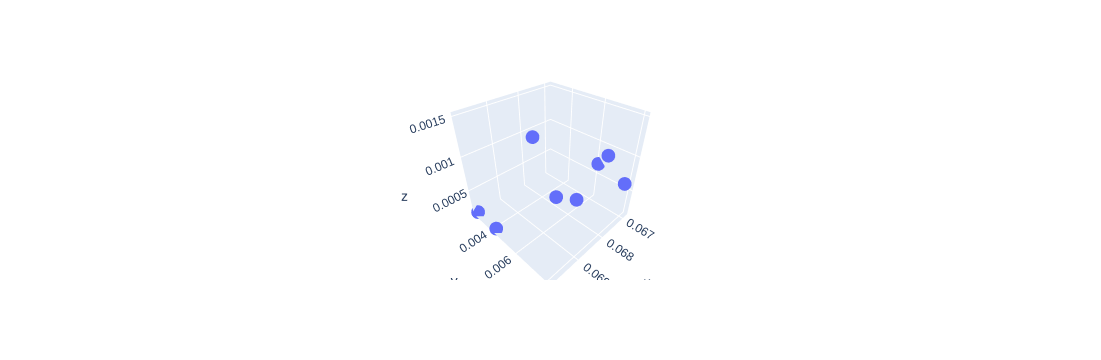

In [85]:
import plotly.express as px
import pandas as pd

# Load sample data (e.g., the Iris dataset)
# df = px.data.iris() 

df_subset = df_out[['x','y','z']].loc[test1_ls]
test1_invdict = {}
for k,v in test1_dict.items():
    test1_invdict[v] = k



import plotly.graph_objects as go

fig = go.Figure()

for i in range(len(df)):
    fig.add_trace(go.Scatter3d(
        x=[df_subset['x'].iloc[i]],
        y=[df_subset['y'].iloc[i]],
        z=[df_subset['z'].iloc[i]],
        mode='markers+text',
        text=[f"P{test1_invdict[df_subset.index]}"],   # label (change as needed)
        textposition='top center',
        marker=dict(size=5)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=700
)

fig.show()

In [14]:
df_out[( df_out['x']>=0.06630859374999999)  &  ( df_out['x']<=0.06634277343749999) 
& ( df_out['y']>= 0.007724609375000001 )  &  ( df_out['y']<= 0.007758789062500001) 
& ( df_out['z']>= 8.544921875000001e-05)  &  ( df_out['z']<=0.00011962890625000001)] 



,x,y,z,temp,gridsize,gh2x,gh2y,gh2z,gh2mag,Y(H),Y(H2),Y(H2O),Y(H2O2),Y(HO2),Y(N2),Y(O),Y(O2),Y(OH)
10274,0.066343,0.007759,0.000103,667.573499,0.000068,-17.721016,15.046573,-9.224883,25.010642,0.000014,0.006604,0.041462,0.000083,0.000329,0.754217,0.000034,0.197087,0.000170
95756,0.066326,0.007742,0.000085,609.997616,0.000034,-17.982912,14.830507,-9.473670,25.161071,0.000007,0.006782,0.037211,0.000097,0.000353,0.754257,0.000016,0.201155,0.000123
95757,0.066326,0.007742,0.000120,718.208969,0.000034,-18.218437,14.586410,-9.484424,25.191846,0.000020,0.006451,0.046270,0.000070,0.000307,0.754130,0.000048,0.192488,0.000216


In [23]:
df_350[['x','y','z']]

,x,y,z
0,0.069863,0.000137,0.000137
1,0.069863,0.000137,0.000410
2,0.069863,0.000410,0.000137
3,0.069863,0.000410,0.000410
4,0.069863,0.000684,0.000137
...,...,...,...
152446,0.069983,0.017483,0.000120
152447,0.069983,0.017483,0.000154
152448,0.069983,0.017483,0.000188
152449,0.069983,0.017483,0.000222


In [19]:
0.06632568359374999/0.000034

1950.7553998161761

In [57]:
0.06634277343749999/0.000034


1951.2580422794115

In [60]:
diff

[3.417968750000014e-05,
 1.7089843749999202e-05,
 1.7089843750000937e-05,
 3.417968750000014e-05,
 1.7089843749999202e-05,
 1.7089843750000937e-05,
 3.417968749999927e-05,
 1.708984375000007e-05,
 1.708984375000007e-05,
 3.417968750000014e-05,
 1.708984375000007e-05,
 1.708984375000007e-05,
 3.417968750000014e-05,
 1.7089843749999202e-05,
 1.7089843750000937e-05,
 3.417968750000014e-05,
 1.7089843749999202e-05,
 1.7089843750000937e-05,
 3.417968749999927e-05,
 1.708984375000007e-05,
 1.708984375000007e-05,
 3.417968749999927e-05,
 1.708984375000007e-05,
 1.708984375000007e-05,
 3.417968750000014e-05,
 1.708984375000007e-05,
 1.7089843749999202e-05,
 3.417968750000014e-05,
 1.7089843750000937e-05,
 1.7089843749999202e-05,
 3.417968750000014e-05,
 1.7089843750000937e-05,
 1.7089843749999202e-05,
 3.417968750000014e-05,
 1.708984375000007e-05,
 1.7089843749999202e-05,
 3.417968750000014e-05,
 1.7089843750000937e-05,
 1.7089843749999202e-05,
 3.417968750000014e-05,
 1.708984375000007e-05,
